In [1]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm

from IPython.display import clear_output

from utils import is_enough_ram
from trainer import Trainer, evaluate
from agent import DuelingDQNAgent
from atari_wrappers import make_env
from replay_buffer import ReplayBuffer
from player import play_and_record

%matplotlib inline

/home/donorkin/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


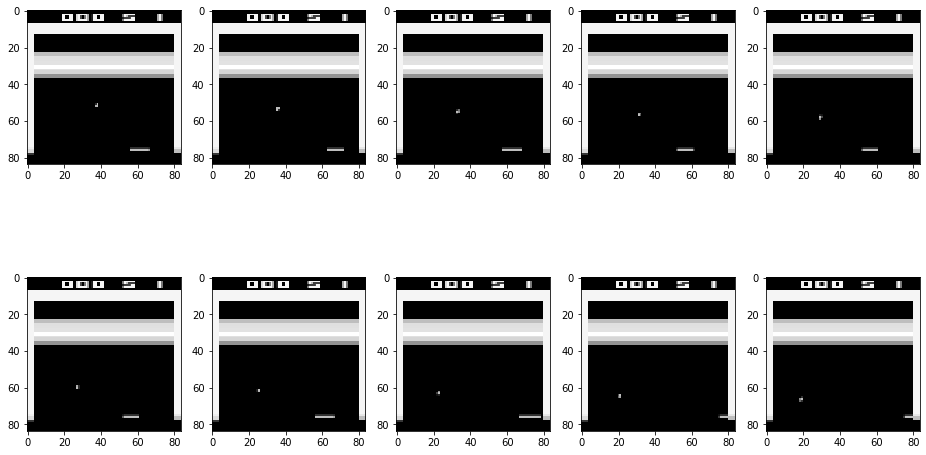

In [3]:
env_name = "BreakoutNoFrameskip-v4"
env = make_env(env_name)

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
env = make_env(env_name=env_name, seed=seed)
state = env.reset()
state_shape = env.observation_space.shape
n_actions = env.action_space.n

In [6]:
agent = DuelingDQNAgent(state_shape, n_actions).to(device)

In [7]:
# buf_size = 10 ** 5
# init_buf_size = 2 * 10**4

# exp_replay = ReplayBuffer(buf_size)

# while True:
#     if not is_enough_ram(min_available_gb=0.1):
#         print("""
#             Less than 100 Mb RAM available. 
#             Make sure the buffer size in not too huge.
#             Also check, maybe other processes consume RAM heavily.
#             """
#             )
#         break
        
#     play_and_record(state, agent, env, exp_replay, n_steps=10**2)
#     clear_output(True)
#     print('{}/{}'.format(len(exp_replay), init_buf_size))
    
#     if len(exp_replay) == init_buf_size:
#         break

In [8]:
exp_replay = torch.load('checkpoints/init_replay.pth')

In [9]:
trainer = Trainer(agent, env, device)
agent.load_state_dict(torch.load('../Practical_RL/week04_approx_rl/models/best_agent.pth'))
trainer.opt.load_state_dict(torch.load('../Practical_RL/week04_approx_rl/models/best_opt.pth'))

In [12]:
trainer.opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 3e-05
    weight_decay: 0
)

In [13]:
for g in trainer.opt.param_groups:
    g['lr'] = 6e-05

buffer size = 100000, epsilon = 0.08000


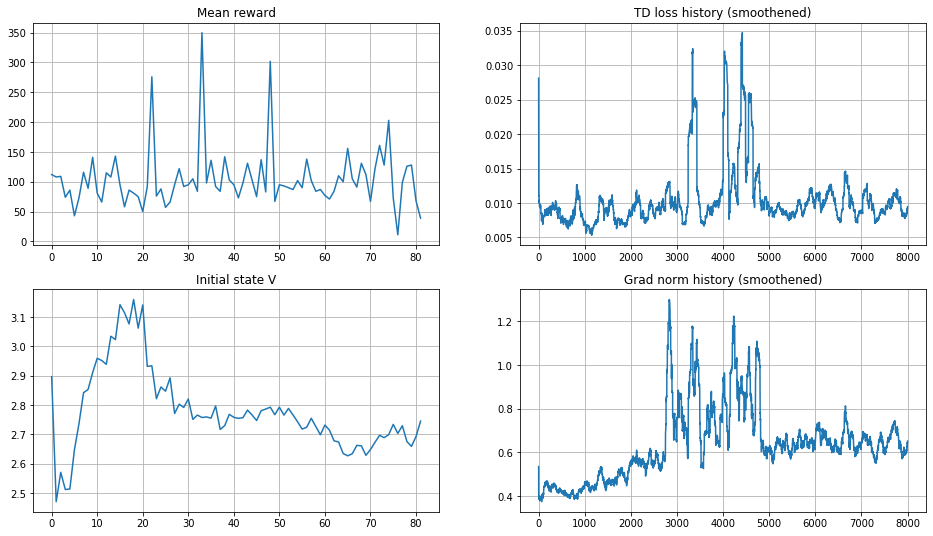

  0%|          | 5597/9596048 [05:13<151:04:23, 17.63it/s] 

In [ ]:
trainer.fit(exp_replay, checkpoint_dir='checkpoints', gif_dir='gifs', init_epsilon=0.08, final_epsilon=0.08)